In [17]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

from models import ResNet
from models import UNet
from models import skip
from utls import *
# from utils.inpainting_utils import *

# dtype for MAC
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark =False
dtype = torch.FloatTensor

In [19]:
img_path = 'Dataset/Training_Data/Cat/Unmasked_Train/Cat-Train (1).jpeg'
mask_path = 'Dataset/Training_Data/Cat/Masked_Train/Cat-Train (1).jpeg'

PLOT = True
NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

In [20]:
img_pil, img_np = get_image(img_path, 256)
img_mask_pil, img_mask_np = get_image(mask_path, 256)

img_arr = pil_to_np(img_pil)
img_mask_arr = pil_to_np(img_mask_pil)

In [21]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [22]:
INPUT = 'meshgrid'
input_depth = 2
LR = 0.01
num_iter = 5000
param_noise = False
show_every = 500
figsize = 5
reg_noise_std = 0.03

net = skip(input_depth, img_np.shape[0], 
           num_channels_down = [128] * 5,
           num_channels_up   = [128] * 5,
           num_channels_skip = [0] * 5,  
           upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

net = net.type(dtype)
net_input = get_noise(input_depth, 
                      INPUT, 
                      (img_np.shape[1], img_np.shape[2])
                      ).type(dtype)


In [23]:
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 2157955


Starting optimization with ADAM


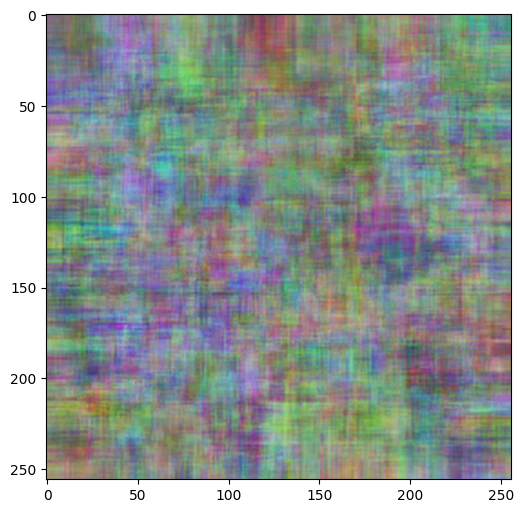

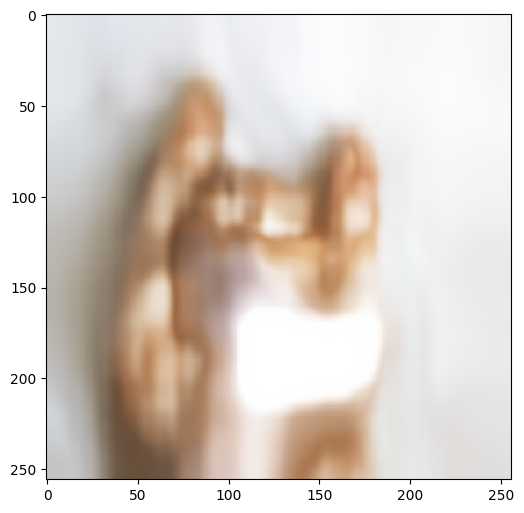

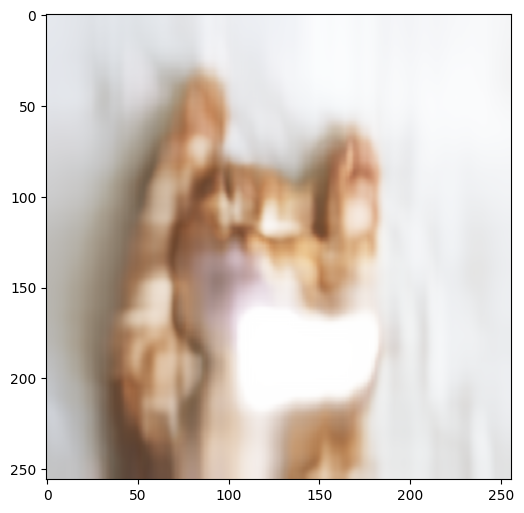

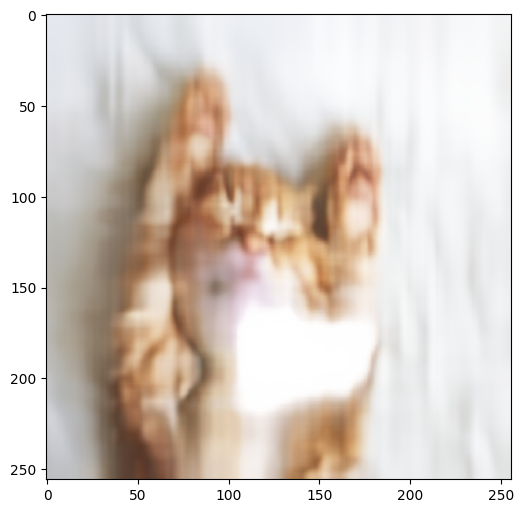

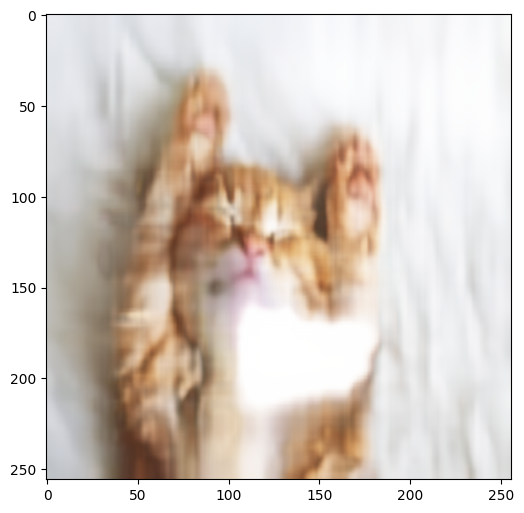

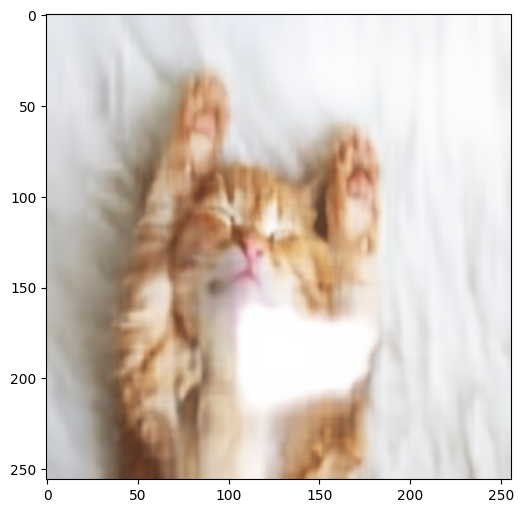

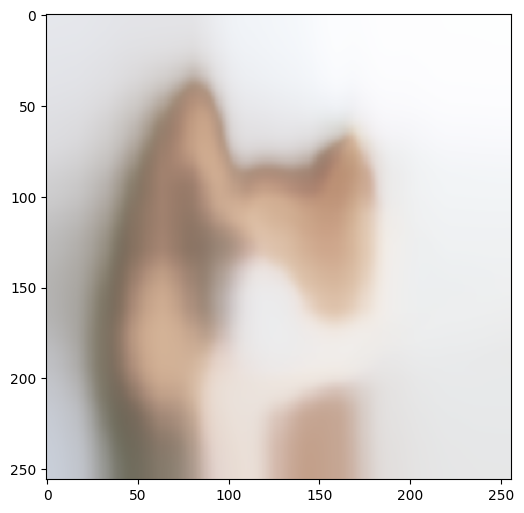

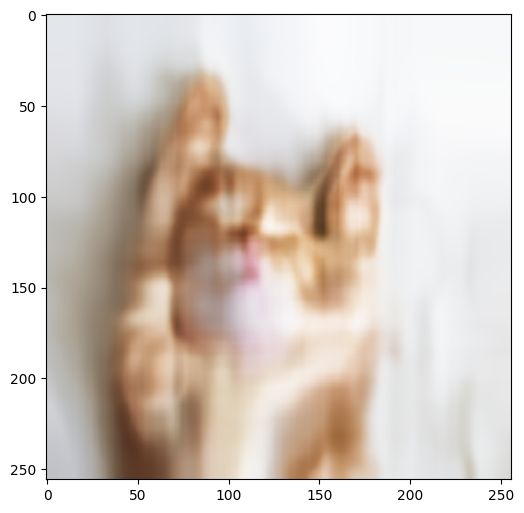

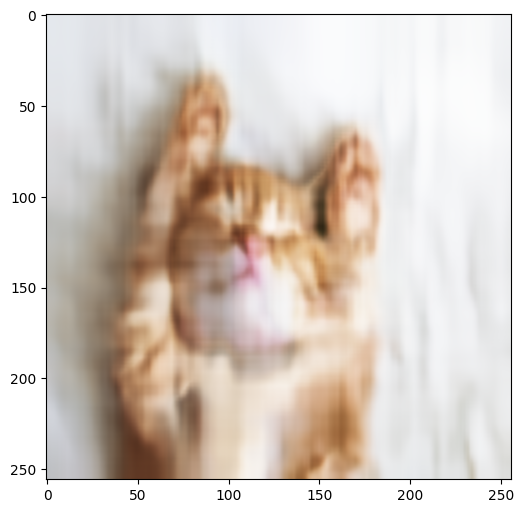

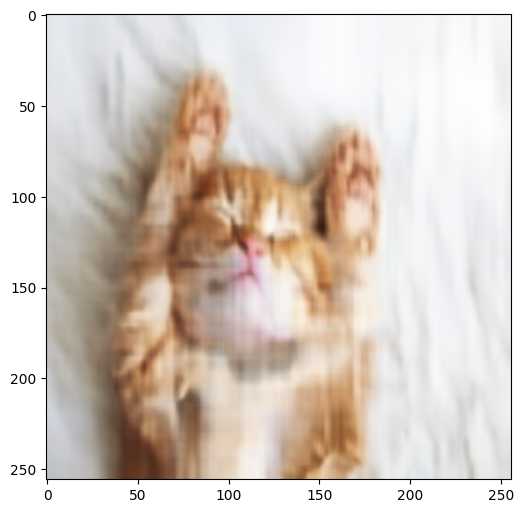

In [24]:
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

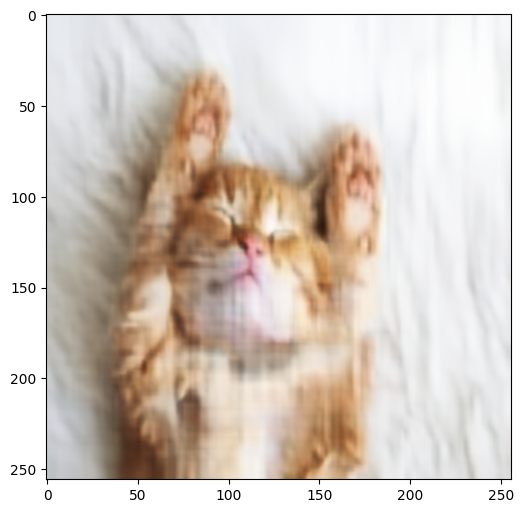

In [25]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);